# Домашнее задание 3

В файле `games.csv` собран датасет по посещаемости 80 популярных игр (да-да, аналогично предыдущей дз). Нам нужен был достаточно гомогенный датасет. Так как посещаемость в первые дни после выхода игры обычно аномальная, рекомендуется внимательно посмотреть на начало рядов и при необходимости отсечь часть стартовых наблюдений.

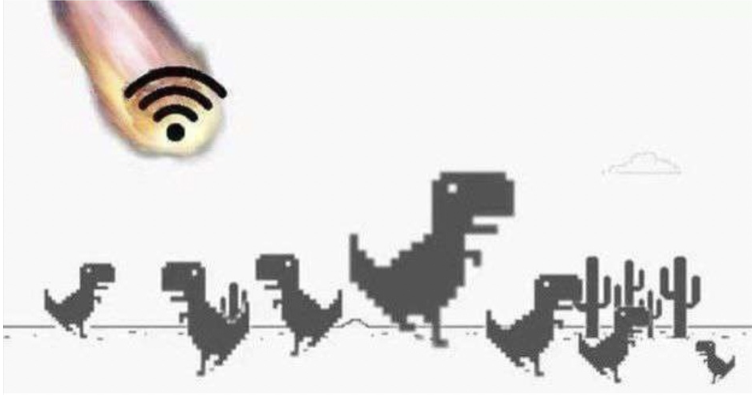

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Pyatachokk/hse_ts_course/refs/heads/master/2025-spring/homeworks/hw3/games.csv')
df.head(3)

,DateTime,Left 4 Dead 2,FINAL FANTASY XIV Online,Terraria,RimWorld,The Elder Scrolls V: Skyrim Special Edition,Soundpad,Destiny 2,Cyberpunk 2077,Total War: WARHAMMER III,...,Euro Truck Simulator 2,Sid Meier's Civilization VI,VRChat,HELLDIVERS™ 2,Valheim,Red Dead Redemption 2,ELDEN RING,THRONE AND LIBERTY,Delta Force,Waifu
0,2005-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(7385, 81)

In [ ]:
df_notnull = (df.notnull().sum()).sort_values(ascending = False)
df_notnull[:10]

,0
DateTime,7385
Garry's Mod,5778
Team Fortress 2,5653
Left 4 Dead 2,5482
Sid Meier's Civilization V,5264
Terraria,5027
Dota 2,4921
Counter-Strike 2,4717
Euro Truck Simulator 2,4372
Warframe,4349


Возьмем кс, пропусков не очень много, мб будет интересно поработать с рядом.

# 1. SARIMA (2 балла)

Для этого раздела выберите наиболее близкую вам игру, или же возьмите случайную. Во всех рядах возьмём недельную сезонность с периодом 7. Она по структуре данных ожидается наиболее сильной.

<Axes: >

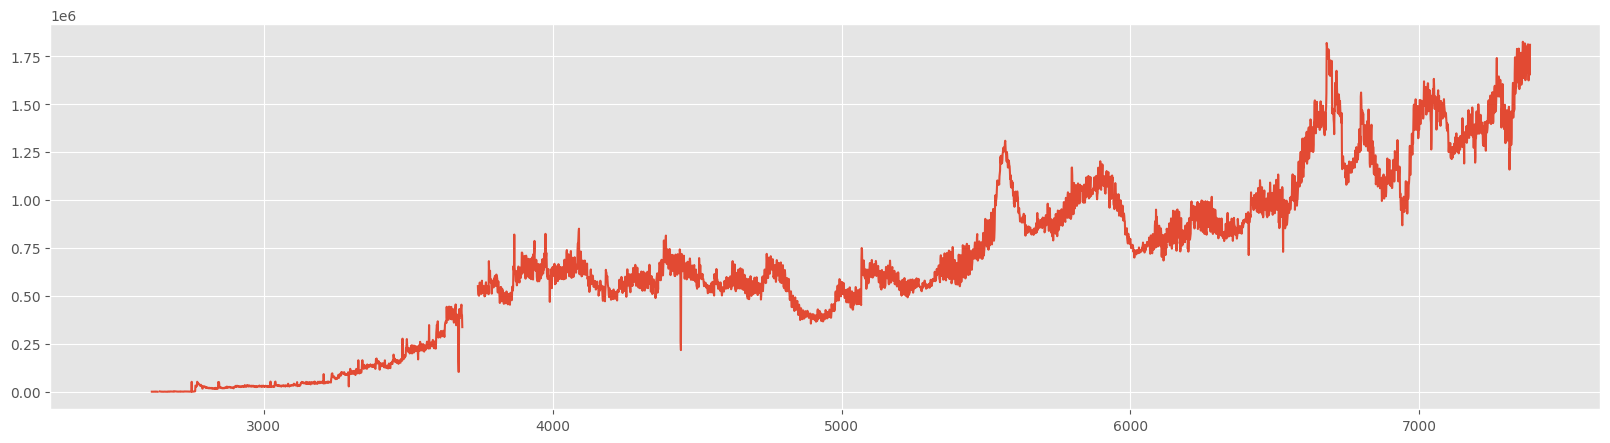

In [ ]:
data = df['Counter-Strike 2']
data.plot()

(0.5 балла)
Отберите параметр D на основе силы сезонности STL.

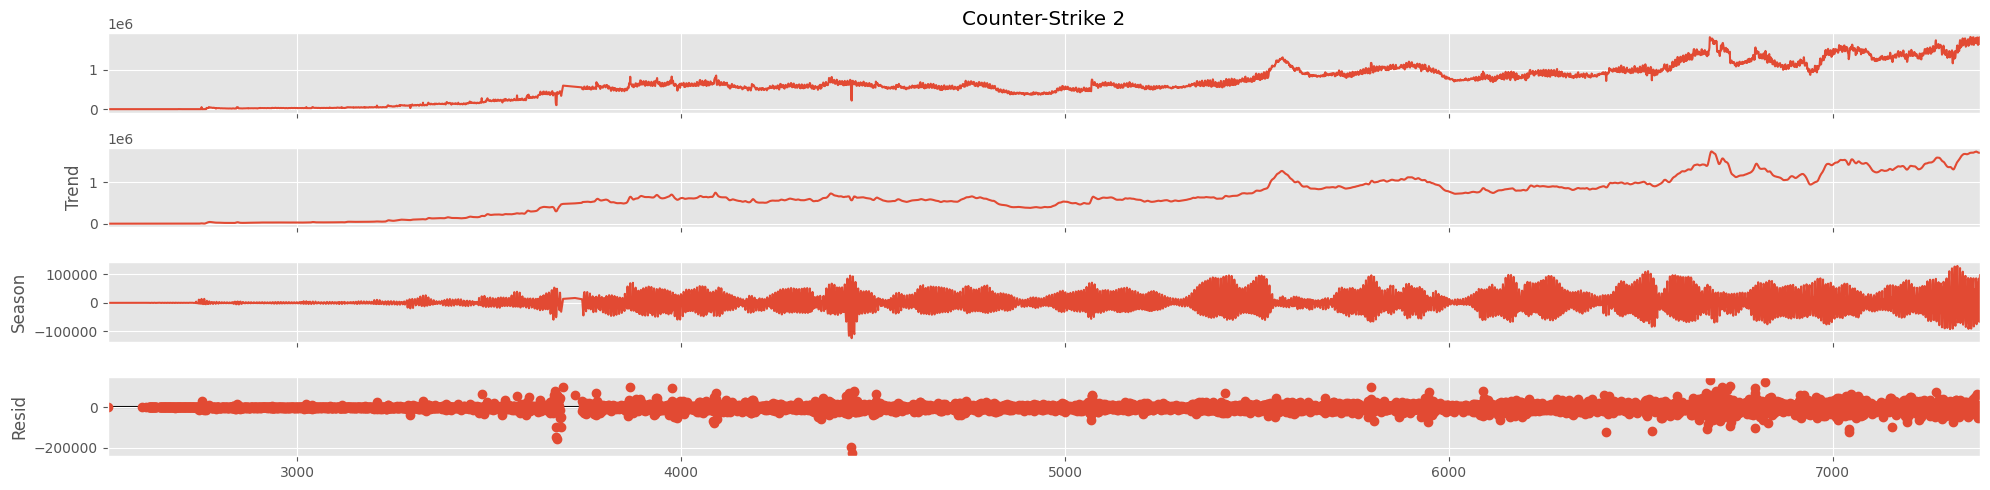

In [ ]:
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

res = STL(data.dropna(), period = 7).fit()
res.plot()
plt.show()

Присутствует восходящий тренд, эта инфа нам нужна будет для следующего номера.

In [ ]:
1 - np.var(res.resid) / np.var(res.resid + res.seasonal) # доля дисперсии ошибок ряда, которая объясняется сезонностью.
# Эта штука называется долей сезонности или Д стат

0.7634747616754582

Полученное значение скорее ближе к 1, чем к 0, делаем вывод, что сезонность достаточно сильная и объясняет большую достаточно долю вариации ошибки, D = 1.

In [ ]:
data_new = data.diff(7).dropna()

Да, действительно, видна недельная сезонность

(0.5 балла) Отберите параметр d на основе ADF или KPSS. Убедитесь, что правильно специфицировали тесты. Аргументируйте ваш выбор. Ваша спецификация должна быть согласована со структурой данных.

Проведем сразу 2 теста, чтобы уж наверняка определить d. По части спецификации - в прошлом пункте явно увидели трендовую составляющую, поэтому устанавливаем
 regression='ct', чтобы учесть и константу и тренд.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_result = adfuller(data_new.dropna(), regression='ct')
adf_result

(np.float64(-10.919421155508713),
 np.float64(3.172497724372193e-17),
 28,
 4663,
 {'1%': np.float64(-3.9607127841892056),
  '5%': np.float64(-3.411431955799926),
  '10%': np.float64(-3.127604673549659)},
 np.float64(110229.98709242813))

Пи значение очень мало, гипотеза о нестационарности ряда отвергается - ряд стационарен, все ок, на всякий случай еще глянем kpss

In [ ]:
kpss(data_new.dropna(), regression='ct')

<ipython-input-10-c6fc46e9e4b5>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(data_new.dropna(), regression='ct')


(np.float64(0.027880752102961336),
 np.float64(0.1),
 30,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

Так как ряд стационарен, то d = 0 - нет необходимости брать первые разности. Пи-значение больше 0.1

(0.5 балла) Примените к ряду разности согласно D и d. Изобразите ACF и PACF для стационарного ряда.

К ряду применили только D=1, известно, что d = 0.

<Axes: >

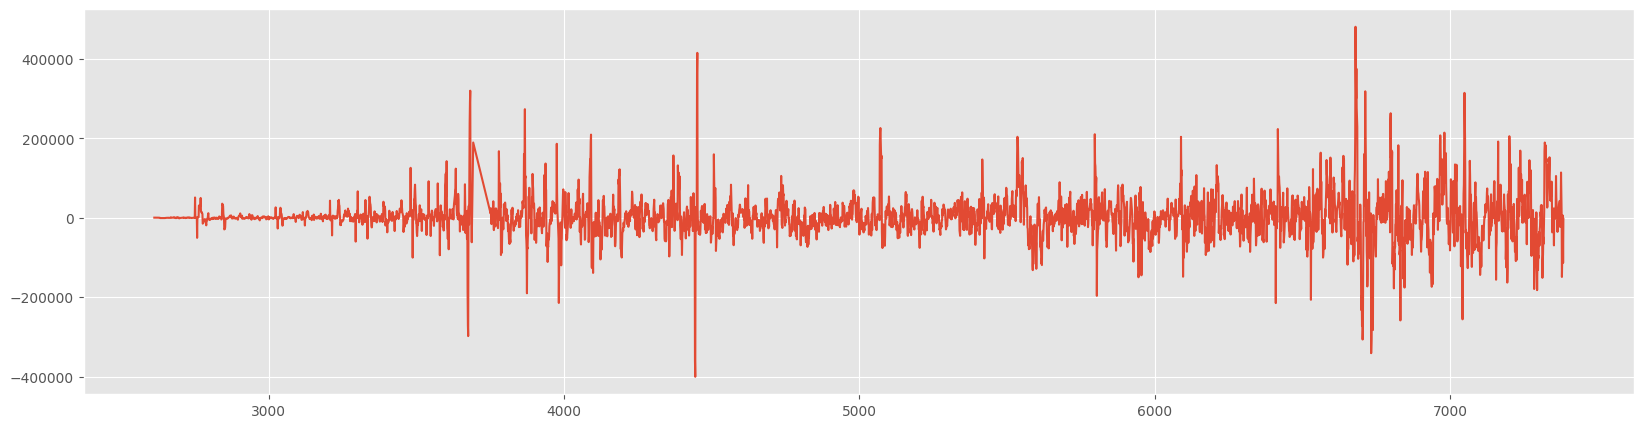

In [ ]:
data_new.plot()

Дисперсия нестабильна во времени, нет явного тренда, средний уровень примерно 0.

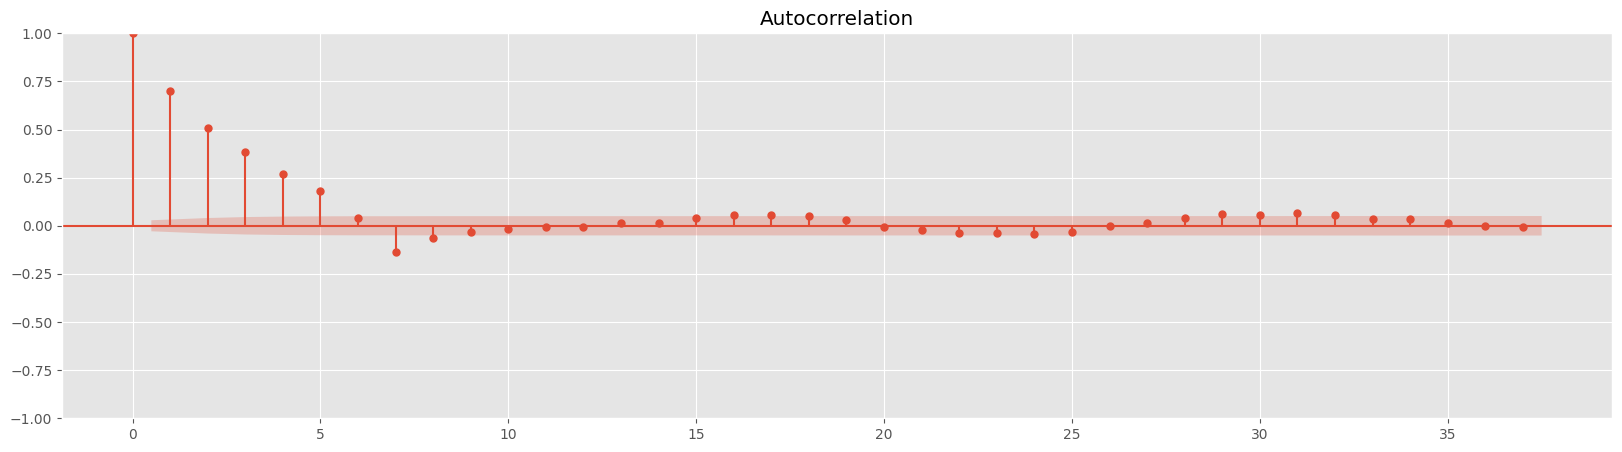

In [ ]:
plot_acf(data_new)
plt.show()

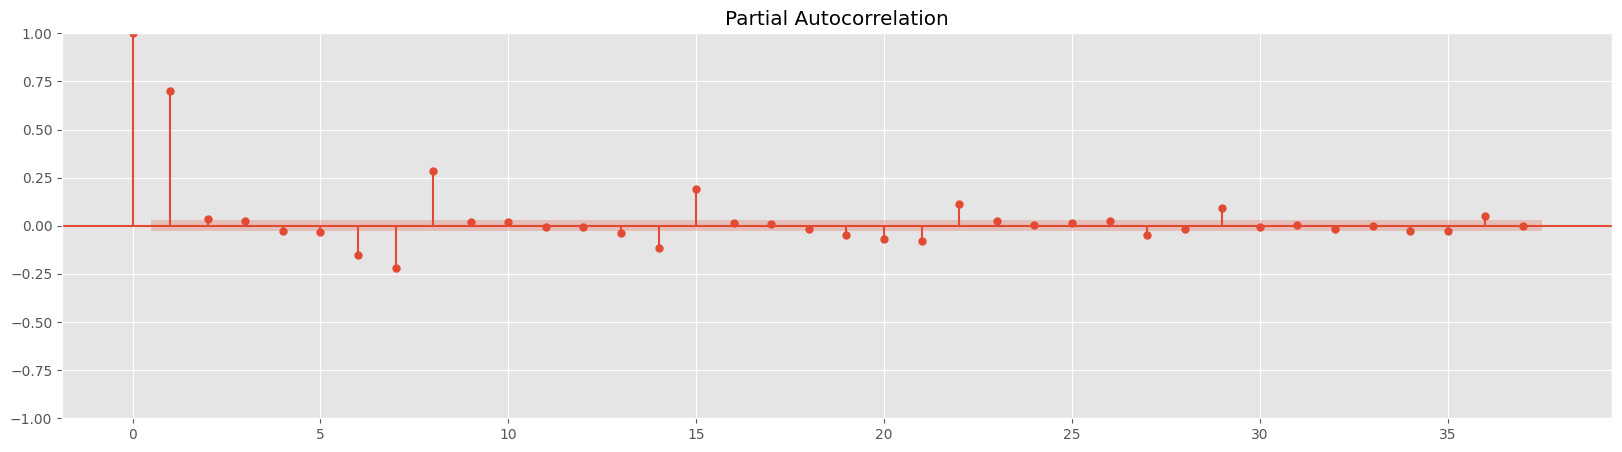

In [ ]:
plot_pacf(data_new)
plt.show()

Все так же видим недельную сезонность

(0.5) Определите по коррелограммам параметры P,Q,p,q или их границы в случае неоднозначности. Подберите оптимальные параметры по AIC. Длину трейна и горизонт прогнозирования специфицируйе самостоятельно, выбор обоснуйте.

По графику ACF видна значимая положительная связь между первыми 5 лагами, обрывается после лага 5, это типично для МА(q = 5). Есть сезонный пик на лаге 7, а значит сезонная компонента Q = 1.

По графику PACF видим значимый пик на лаге 1 и 2 - несезонная часть, а так же лаг 7 - сезонность выходных дней, когда резко актив в игре повышается относительно рабочих дней, тогда p = 1 or 2, а P = 1 (сезонность недельная).

In [ ]:
train = data[:-12]
test = data[-12:]

In [ ]:
import statsmodels.api as sm

p_values = [1, 2]
q_values = [3,4,5]
P_values = [1]
Q_values = [1]
d = 0
D = 1
s = 7

best_aic = float('inf')
for p in p_values:
  for q in q_values:
    for P in P_values:
      for Q in Q_values:
        model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit()
        print(f'Model SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - AIC: {results.aic:.2f}')

        if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_seasonal_order = (P, D, Q, s)
                        best_model = results

print("\nЛучший результат:")
print(f"Order: {best_order}")
print(f"Seasonal order: {best_seasonal_order}")
print(f"AIC: {best_aic:.2f}")

Model SARIMA(1,0,3)x(1,1,1,7) - AIC: 110935.54
Model SARIMA(1,0,4)x(1,1,1,7) - AIC: 110921.82
Model SARIMA(1,0,5)x(1,1,1,7) - AIC: 110872.95


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model SARIMA(2,0,3)x(1,1,1,7) - AIC: 110837.32
Model SARIMA(2,0,4)x(1,1,1,7) - AIC: 110928.10
Model SARIMA(2,0,5)x(1,1,1,7) - AIC: 110864.97

Лучший результат:
Order: (2, 0, 3)
Seasonal order: (1, 1, 1, 7)
AIC: 110837.32


# 2. Проверка гомогенности (2 балла)

Попробуем понять, достаточно ли однороден наш датасет. Будем использовать все ряды из датасета. Для ускорения расчётов ресэмплируйте дневные данные к недельным с помощью усреднения. В этом разделе будем оценивать только модели без сезонности, так как при усреднении она исчезнет.

Разделите данные на трейн и тест. Последние 16 недель каждого ряда будут тестовой выборкой.

In [ ]:
df.DateTime = pd.to_datetime(df.DateTime)
df.set_index('DateTime', inplace = True)
df = df.resample('W').mean()
y_train = df.iloc[:-16]
y_test = df.iloc[-16:]

(0.5 балла) Оцените автоматическую ARIMA на трейне каждого ряда. Можете использовать nixtla или pmdarima. Сохраните результат оценки.

In [ ]:
df_long = y_train.reset_index().melt(id_vars='DateTime', var_name='unique_id', value_name='y')
df_long = df_long.rename(columns={'DateTime': 'ds'}).dropna()
df_long.head(3)

,ds,unique_id,y
253,2009-11-29,Left 4 Dead 2,19641.333333
254,2009-12-06,Left 4 Dead 2,23667.333333
255,2009-12-13,Left 4 Dead 2,21558.500000


In [ ]:
!pip install statsforecast

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from statsforecast.models import AutoARIMA

ОСТОРОЖНО!!! Грузится 10 минут

Здесь подбираем гиперпараметры 74 раза с помощью автоаримы

In [ ]:
results = []
# тут df_long - это трейн, только его перевели в спец формат - длинный, это сама автоарима требует
for uid in tqdm(df_long['unique_id'].unique()):
    series = pd.Series(
        df_long.loc[df_long['unique_id'] == uid, 'y'].values,
        index=pd.to_datetime(df_long.loc[df_long['unique_id'] == uid, 'ds'])
    )

    model = AutoARIMA(season_length=7)
    model.fit(series)

    p, d, q, P, D, Q, s = model.model_['arma']

    results.append([uid, p, d, q, P, D, Q, s])

100%|██████████| 74/74 [11:14<00:00,  9.11s/it]


In [ ]:
spec_df = pd.DataFrame(results, columns=['unique_id', 'p', 'd', 'q', 'P', 'D', 'Q', 's'])
spec_df.to_csv("arima_model_params.csv", index=False)

In [ ]:
spec_df.head(3)

,unique_id,p,d,q,P,D,Q,s
0,Left 4 Dead 2,5,1,0,0,1,1,0
1,FINAL FANTASY XIV Online,1,2,0,0,1,1,0
2,Terraria,3,1,1,0,7,1,0


ОСТОРОЖНО!!! РАБОТАЕТ 9 МИНУТ!!!

Здесь предсказания на параметрах, которые подобрала автоарима.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

forecast_results = []

for idx, row in tqdm(spec_df.iterrows()):
    uid = row['unique_id']
    p, d, q, P, D, Q, s = row[['p', 'd', 'q', 'P', 'D', 'Q', 's']]

    df_game = df_long[df_long['unique_id'] == uid]
    series = pd.Series(
        df_game['y'].values,
        index=pd.to_datetime(df_game['ds'])
    )

    if s == 0: # это мы предполагаем недельную сезонность, иначе не сможем запустить сариму
        s = 7

    model = SARIMAX(series,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s))
    model = model.fit(disp=False)
    forecast = model.forecast(steps=16)

    forecast_results.append({
        'unique_id': uid,
        'forecast': forecast.tolist()
    })

74it [08:36,  6.98s/it]


In [ ]:
forecast_df_auto_arima = pd.DataFrame(forecast_results)
forecast_df_auto_arima.to_csv("sarima_forecast.csv", index=False)

In [ ]:
forecast_df_auto_arima.head(3)

,unique_id,forecast
0,Left 4 Dead 2,"[36491.81516400176, 38398.28635169551, 37851.9..."
1,FINAL FANTASY XIV Online,"[20967.93112938483, 20411.006104389027, 19907...."
2,Terraria,"[3366403.461876254, 3465835.6764136124, 103824..."


(0.5 балла) Выявите топ-3 самых частых спецификаций рядов. Возьмите из них одну с максимальным количеством параметров. Идея в том, чтобы взять достаточно обобщающую модель для всех рядов в выборке. Будем называть эту модель универсальной.

In [ ]:
spec_df.head(3)

,unique_id,p,d,q,P,D,Q,s
0,Left 4 Dead 2,5,1,0,0,1,1,0
1,FINAL FANTASY XIV Online,1,2,0,0,1,1,0
2,Terraria,3,1,1,0,7,1,0


In [ ]:
spec_cols = ['p', 'd', 'q', 'P', 'D', 'Q', 's']
spec_counts = spec_df.groupby(spec_cols).size().reset_index(name='count').sort_values(by='count', ascending = False)
spec_counts[:3]

,p,d,q,P,D,Q,s,count
20,1,2,0,0,1,1,0,9
0,0,0,0,0,1,0,0,5
4,0,1,0,0,1,1,0,3


Это топ 3 самых популярных спецификаций, у самой популярной модели больше всего параметров из моделей финалистов, скажем, что это наша "универсальная" модель.

In [ ]:
universal_model_params = spec_counts.iloc[0][spec_cols].to_dict()
print(universal_model_params)

{'p': 1, 'd': 2, 'q': 0, 'P': 0, 'D': 1, 'Q': 1, 's': 0}


Тут мы нашли универсальную модель, но с такими параметрами вечно вылетало LinAlgError: Schur decomposition solver error, я попробовала взять несезонные параметры, которые были бы похожи на {'p': 1, 'd': 2, 'q': 0} и которые бы позволили предсказания сделать в принципе.

Там просто в трейне есть ряды, у которых куча пропусков и мало значений после агрегации до недельной частоты.

In [ ]:
forecast_results = []

for uid in tqdm(df_long['unique_id'].unique()):
    # p, d, q, P, D, Q, s = universal_model_params.values()

    df_game = df_long[df_long['unique_id'] == uid]
    series = pd.Series(
        df_game['y'].values,
        index=pd.to_datetime(df_game['ds'])
    )

    # if s == 0:
    #     s = 7

    # model = SARIMAX(series,
    #                 order=(p, d, q),
    #                 seasonal_order=(P, D, Q, s))

    model = SARIMAX(series,
                    order=(0, 1, 0),
                    seasonal_order=(0, 1, 1, 7))

    model = model.fit(disp=False)
    forecast = model.forecast(steps=16)

    forecast_results.append({
        'unique_id': uid,
        'forecast': forecast.tolist()
    })

100%|██████████| 74/74 [00:31<00:00,  2.32it/s]


In [ ]:
forecast_df_universal = pd.DataFrame(forecast_results)
forecast_df_universal.head(3)

,unique_id,forecast
0,Left 4 Dead 2,"[34522.59246186456, 34904.0298593559, 34564.48..."
1,FINAL FANTASY XIV Online,"[22018.333552205117, 22380.627707188323, 22829..."
2,Terraria,"[38740.80913897472, 38172.13412489401, 39488.2..."


(1 балл) Для каждого ряда проведите на тестовой выборке односторонний тест Диболда-Мариано.

Нулевая гипотеза: прогнозы универсальной и автоматической моделей не различаются

Альтернативная гипотеза: автоматическая модель лучше

Выведите долю рядов, для которых гипотеза не отверглась. Получилось ли описать единой моделью значимое количество рядов?

In [ ]:
from statsmodels.tools.eval_measures import mse

dm_test_results = []

for idx, row in tqdm(forecast_df_universal.iterrows()):
    uid = row['unique_id']

    forecast_universal = row['forecast']
    forecast_auto_arima = forecast_df_auto_arima.loc[forecast_df_auto_arima['unique_id'] == uid, 'forecast'].values[0]

    forecast_universal = np.array(forecast_universal)
    forecast_auto_arima = np.array(forecast_auto_arima)

    df_game = df_long[df_long['unique_id'] == uid]
    y_true = y_test[uid]  # последние 16 наблюдений

    error_universal = mse(y_true, forecast_universal)
    error_auto_arima = mse(y_true, forecast_auto_arima)

    # cравниваем ошибки: если ошибка автоматической модели меньше, считаем еe лучше
    if error_auto_arima < error_universal:
        dm_test_results.append(1)
    else:
        dm_test_results.append(0)

not_rejected_count = sum(dm_test_results)
not_rejected_percentage = not_rejected_count / len(dm_test_results) * 100

print(f"Доля рядов, для которых гипотеза не отверглась: {not_rejected_percentage:.2f}%")

74it [00:00, 75.12it/s]

Доля рядов, для которых гипотеза не отверглась: 17.57%


# 3. Общие тренды на рынке (1 балл)

В этом разделе нам необходимо построить прогнозные модели для курсов валют. На семинарах мы обсуждали, что прогнозировать цены котировок стандартными линейными моделями довольно бесперспективно. Так как такие данные близки к модели случайного блуждания, оптимальным прогнозом для них часто оказывается наивный. Однако если перейти к более низкой частоте (например, к месячным данным), то некоторого превосходства над наивной всё же можно добиться.

В приложенном датасете currencies.csv находятся следующие величины:
1.  Курсы ряда валют по отношению к доллару.

    Курс EUR/USD - Евро Доллар США
    
    Курс CNY/USD - Китайский юань Доллар США
    
    Курс INR/USD - Индийская рупия Доллар США
    
    Курс JPY/USD - Японская йена Доллар США
    
    Курс GBR/USD - Британский фунт Доллар США
    
    Курс CHF/USD - Швейцарский франк Доллар США
    
    Курс BRL/USD - Бразильский реал Доллар США
    
    Курс IDR/USD - Индонезийская рупия Доллар США

2. Цена нефти BRENT за баррель и цена газа в Европе за mmbtu (Британская тепловая единица)
3. ff_rate -- ставка ФРС США

Нашей задачей будет построить прогнозную модель для всех курсов валют из пункта 1. Цены нефти, газа и ставка ФРС даны дополнительно, можете использовать их если посчитаете необходимым, но в базовой версии можно использовать только временные ряды курсов валют.

### Импорт данных

Импортируйте данные из файла. Приведите информацию о датах в один столбец типа datetime. Например, чтобы каждая точка отображала дату начала месяца.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Pyatachokk/hse_ts_course/refs/heads/master/2025-spring/homeworks/hw3/currencies.csv', sep =';', decimal=',')

In [ ]:
df['date'] = pd.to_datetime(df['Год'].astype(str) + '-' + df['Месяц'].astype(str).str.zfill(2) + '-01')
df.set_index('date', inplace=True)
df.drop(columns=['Год', 'Квартал', 'Месяц'], inplace=True)
df.head(3)

,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
date,,,,,,,,,,,
2000-01-01,25.3800,3.36,1.013610,0.120784,0.022243,0.949539,1.640095,0.629500,0.554614,0.000137,5.45
2000-02-01,27.7048,3.46,0.984514,0.120801,0.022340,0.913322,1.601462,0.612571,0.563276,0.000135,5.73
2000-03-01,27.4700,3.51,0.965026,0.120794,0.022483,0.940342,1.581504,0.601583,0.574004,0.000134,5.85


Писать для каждого ряда одномерную модель несколько расточительно, хотя и не лишено смысла. Этот процесс необходимо автоматизировать. В простом для понимания варианте можно свести прогноз каждой валюты к табличной задаче и подобрать регрессоры из остальных рядов. Мы таким уже занимались, поэтому попробуем зайти с немного другой стороны.

Весь рынок и в частности рынок валют -- единый механизм, находящийся в некотором равновесии и иногда от него отклоняющийся. Значит, у рядов может быть общий тренд. Формально такая ситуация называется коинтеграцией и это тема отдельной лекции, нам она будет нужна только для идеи. Более подробно про коинтеграцию можно почитать вот в этом [конспекте](https://vk.com/doc126754362_567660819?hash=AvDGHaO92KX7exjBCleLZsEGHPPX2iZfCqae2Fijkng).

### 1. (0.5 балла) Визуализация

Давайте увидим это явно. Возьмите все курсы валют, отнормируйте их c помощью StandardScaler из sklearn и изобразите результат на одном графике.

График будет немного шумный, но вы должны заметить что в целом валюты движутся по схожим траекториям, а некоторые группируются.

In [ ]:
from sklearn.preprocessing import StandardScaler
cols = df.columns
currency_data = df[cols]

scaler = StandardScaler()
df = scaler.fit_transform(currency_data)
df = pd.DataFrame(df, columns=cols, index=currency_data.index)
df.head(3)

,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
date,,,,,,,,,,,
2000-01-01,-1.383872,-0.690773,-1.152026,-1.414994,0.962464,0.083916,0.446090,-1.814331,1.260178,2.356056,1.955792
2000-02-01,-1.304316,-0.678671,-1.336002,-1.413890,0.987861,-0.188512,0.270214,-1.916215,1.325716,2.200227,2.102712
2000-03-01,-1.312351,-0.672620,-1.459230,-1.414350,1.025675,0.014733,0.179359,-1.982351,1.406888,2.169050,2.165678


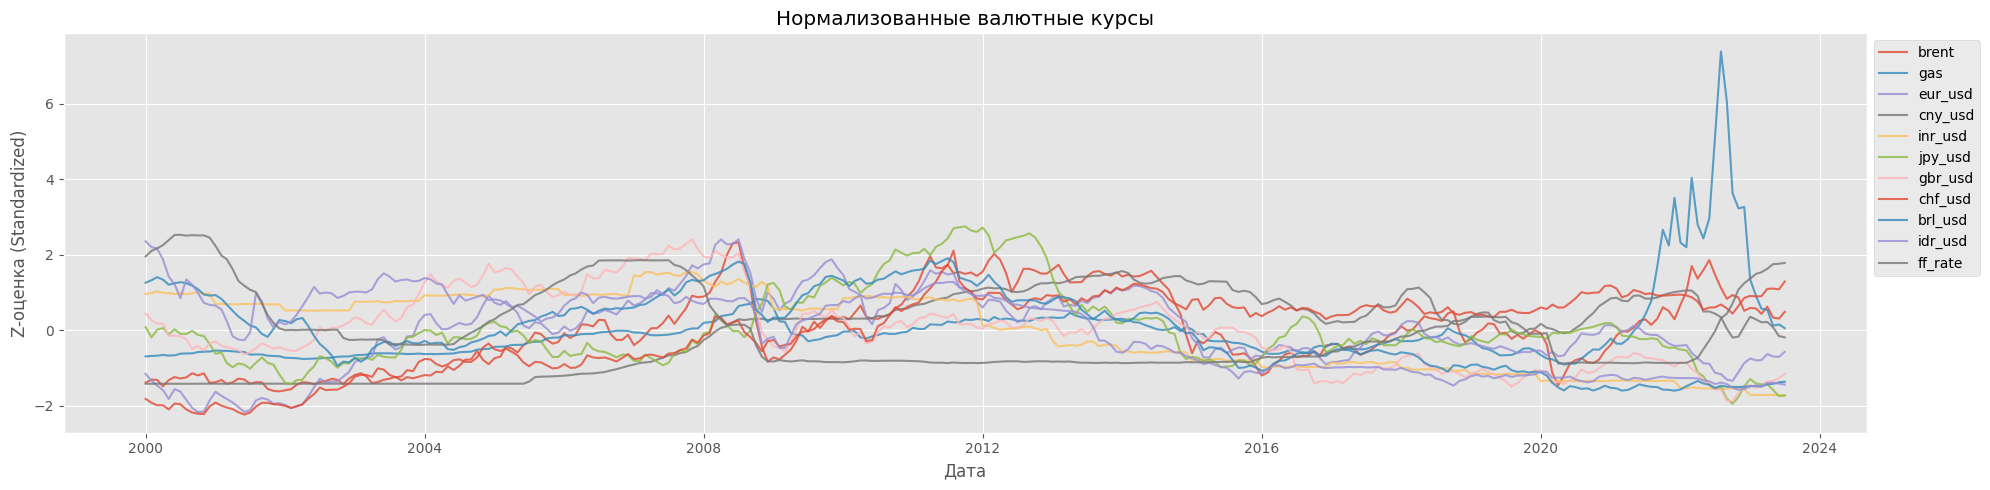

In [ ]:
for column in df.columns:
    plt.plot(df.index, df[column], label=column, alpha=0.8)

plt.title('Нормализованные валютные курсы')
plt.xlabel('Дата')
plt.ylabel('Z-оценка (Standardized)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

Можно ли выделить эти общие тренды на рынке? Да. Можно просто рассмотреть все валюты как один многомерный вектор и понизить его размерность. Либо оценить VAR-модель и вывести явно коинтеграционное соотношение (уравнение равновесия на рынке). Второй подход нам не подходит из-за малого количества данных для стольких уравнений, поэтому используем первый.

Конечно, для временных рядов существуют специфические методы понижения размерности, но они выходят за рамки нашего курса. Поэтому мы воспользуемся не слишком подходящим, но зато простым и знакомым методом главных компонент (PCA). PCA никак не учитывает временную зависимость точек, но мы позволим себе пренебречь этим.

### 2. (0.5 балла) Визуализация главных компонент

Примените PCA на рядах из восьми валют и отберите три первые главные компоненты. Изобразите их на одном графике. Сравните с предыдущим графиком. Компоненты будут примерно похожи на тренды нескольких разных групп валют.

In [ ]:
df.head(3)

,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
date,,,,,,,,,,,
2000-01-01,-1.383872,-0.690773,-1.152026,-1.414994,0.962464,0.083916,0.446090,-1.814331,1.260178,2.356056,1.955792
2000-02-01,-1.304316,-0.678671,-1.336002,-1.413890,0.987861,-0.188512,0.270214,-1.916215,1.325716,2.200227,2.102712
2000-03-01,-1.312351,-0.672620,-1.459230,-1.414350,1.025675,0.014733,0.179359,-1.982351,1.406888,2.169050,2.165678


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df)
pca_df = pd.DataFrame(
    principal_components,
    columns=['PC1', 'PC2', 'PC3'],
    index=df.index)

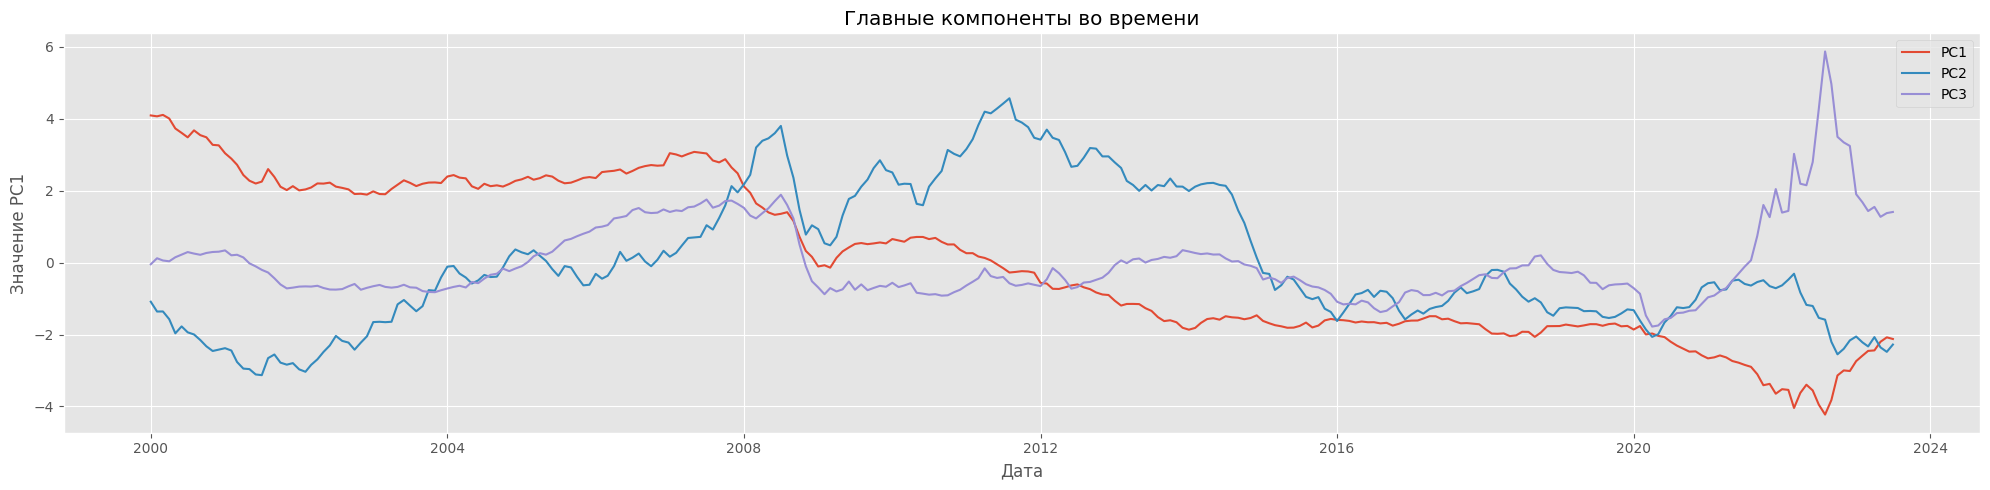

In [ ]:
plt.plot(pca_df.index, pca_df['PC1'], label='PC1')
plt.plot(pca_df.index, pca_df['PC2'], label='PC2')
plt.plot(pca_df.index, pca_df['PC3'], label='PC3')
plt.title('Главные компоненты во времени')
plt.xlabel('Дата')
plt.ylabel('Значение PC1')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Итоговое замечание: На рынках есть некоторое глобальное равновесие (коинтеграционное соотношение). Если бы рядов было немного, мы могли бы построить VAR на нестационарных рядах за счёт этого общего тренда. Однако у нас такой возможности нет и придётся колхозить понижение размерности и строить на его основе стационарный VAR.

# 3. Автокодировщик на стероидах (5 баллов)

Попробуем обойти ограничение на количество рядов. Понизим размерность данных, построим VAR на двух-трёх мерном пространстве, а потом декодируем прогнозы.



 Модель будет устроена следующим образом.

1. Энкодер. Строим PCA на всех валютах (и доп фичах, если хотите) сразу, выделяем главные компоненты.
2. Декодер. PCA не обратим в стандартном понимании, нельзя аналитически получить из главных компонент обратно исходные ряды. Для каждой валюты обучаем регрессионную модель, предсказывающую курс валюты по главным компонентам. Если у нас 8 валют, здесь получится 8 моделей. Модели можно взять любые (линрег, бустинг, ...). Не мучайтесь с подбором гиперпараметров, бустинга из коробки хватит.
2. Строим VAR(p)-модель только на главных компонентах
4. Прогнозируем главные компоненты вперёд
5. Применяем модели-декодеры, чтобы получить из прогнозов главных компоненты прогнозы валют


(0.5 балла) Необходимо сделать препроцессинг данных, так как нам нужно будет строить VAR на стационарных рядах. Мы не уверены, что на PCA-рядах будет существовать коинтеграция. Приведите все ряды к стационарному виду.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

def check_stationarity(series):
    series = series.dropna()
    adf_p = adfuller(series, regression='c')[1]
    kpss_p = kpss(series, regression='c')[1]
    return adf_p < 0.05 and kpss_p < 0.05


def make_stationary(df: pd.DataFrame, max_diff: int = 3):
    df_stationary = df.copy()
    diff_info = {}

    for col in df.columns:
        series = df[col]
        diff_count = 0

        while True:
            if check_stationarity(series):
                break
            series = series.diff().dropna()
            diff_count += 1
            if diff_count > max_diff:
                print(f"{col}: ❗ проблема с рядом, больше {max_diff} разностей")
                break

        df_stationary[col] = series
        diff_info[col] = diff_count
        print(f"{col}:✅ дифференцировали {diff_count} раз(а)")
    return df_stationary, diff_info

1. (0.5 балла) Реализуйте метод fit_pca, который вычисляет главные компоненты от всех валют и дополнительных переменных и сохраняет их. Компонент может быть не более трёх, либо не более 95% объяснённой дисперсии.

2. (0.5 балла) Реализуйте метод fit_var. В нём необходимо обучить VAR(p)-модель на главных компонентах из предыдущего пункта.

3. (1 балл) Реализуйте метод fit_decoders. Необходимо оценить ряд регрессий, восстанавливающих валюты из главных компонент. Восстанавливать дополнительные переменные не нужно. Заморачиваться с отбором параметров этих моделей не нужно (только при большом желании). Бустинга из коробки должно хватить.

4. (1 балл) Реализуйте метод forecast. VAR прогнозируют главные компоненты, а модели-декодеры восстанавливают из этих прогнозов валюты. Функция должна возвращать датафрейм прогнозов всех валют на 12 шагов. По строкам идут валюты, по столбцам -- горизонты.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
kek = make_stationary(df)[0].dropna()
kek.head(3)

brent: ❗ проблема с рядом, больше 3 разностей
brent:✅ дифференцировали 4 раз(а)
gas:✅ дифференцировали 0 раз(а)
eur_usd: ❗ проблема с рядом, больше 3 разностей
eur_usd:✅ дифференцировали 4 раз(а)
cny_usd: ❗ проблема с рядом, больше 3 разностей
cny_usd:✅ дифференцировали 4 раз(а)
inr_usd: ❗ проблема с рядом, больше 3 разностей
inr_usd:✅ дифференцировали 4 раз(а)
jpy_usd: ❗ проблема с рядом, больше 3 разностей
jpy_usd:✅ дифференцировали 4 раз(а)
gbr_usd: ❗ проблема с рядом, больше 3 разностей
gbr_usd:✅ дифференцировали 4 раз(а)
chf_usd: ❗ проблема с рядом, больше 3 разностей
chf_usd:✅ дифференцировали 4 раз(а)
brl_usd: ❗ проблема с рядом, больше 3 разностей
brl_usd:✅ дифференцировали 4 раз(а)
idr_usd: ❗ проблема с рядом, больше 3 разностей
idr_usd:✅ дифференцировали 4 раз(а)
ff_rate:✅ дифференцировали 0 раз(а)


,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
date,,,,,,,,,,,
2000-05-01,0.566722,-0.667780,-0.045086,0.000856,0.188988,0.580005,-0.421308,-0.198282,0.244969,0.503257,2.386057
2000-06-01,-0.910883,-0.661729,0.711151,-0.004486,-0.152366,0.563166,1.079790,0.540813,0.156861,0.285875,2.522483
2000-07-01,0.382273,-0.618163,-1.427269,-0.000215,0.121581,-1.063706,-1.015097,-0.807417,-0.422887,-0.810432,2.527730


In [ ]:
from statsmodels.tsa.api import VAR
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

class EncoderDecoderForecaster:

    def __init__(self, data:pd.DataFrame, p: int|None = None):
        """
        __init__ Initializing forecaster class

        Arguments:
            data {pd.DataFrame} -- Dataframe of all data
            p {int} -- Order of VAR model
        """
        self.is_pca_fitted = False
        self.is_var_fitted = False

        self.data = data
        self.p = p

        self.decoders = []


    def fit_pca(self, covered_variance=0.95, max_components=3) -> pd.DataFrame:
        """
        fit_pca Fitting PCA on a bunch of currencies

        Arguments:
            features {pd.DataFrame} -- Dataframe of features

        Keyword Arguments:
            covered_variance {float} -- Share of variance, covered by PCA from original data. (default: {0.95})
            max_components {int} -- Maximum number of PCA components, allowed for VAR. Have more priority than covered_variance.

        Returns:
            pd.DataFrame -- Dataframe of principal components
        """
        pca_full = PCA()
        pca_full.fit(self.data)

        cumulative_variance = pca_full.explained_variance_ratio_.cumsum()
        n_components = (cumulative_variance < covered_variance).sum() + 1
        n_components = min(n_components, max_components)

        self.pca = PCA(n_components=max_components)
        self.principal_components = self.pca.fit_transform(self.data)
        self.is_pca_fitted = True

        return pd.DataFrame(self.principal_components)


    def fit_var(self): # тут на 3 гк строим вар модель
        """
         Fitting var on results of PCA
        """

        assert self.is_pca_fitted

        pc_df = pd.DataFrame(
            self.principal_components,
            columns=[f"PC{i+1}" for i in range(self.principal_components.shape[1])],
            index=self.data.index)
        self.pc_df = pc_df
        var = VAR(self.pc_df)
        if self.p is not None:
            self.model = var.fit(self.p)
        else:
            self.model = var.fit(ic='bic')
            self.p = self.model.k_ar
        self.is_var_fitted = True
        print(f"✅ VAR обучен. Использовано {self.p} лагов.")

    def fit_decoders(self): # тут пытаемся из гк восстановить приросты курсов

        """
         Fitting decoders from PCA to original data
        """

        self.decoders = {}
        for col in self.data.columns:
          model = GradientBoostingRegressor()
          model.fit(self.pc_df, self.data[col])
          self.decoders[col] = model
        assert len(self.decoders) > 0
        self.is_decoder_fitted = True

    def forecast(self, h: int = 12) -> pd.DataFrame:
        """
        forecast Forecast VAR and decode it's forecasts with decoder-models.

        Keyword Arguments:
            h {int} -- Forecasting horizon (default: {1})

        Returns:
            pd.DataFrame -- Forecasts of all currencies. Horizon by columns. Currencies by rows.
        """

        assert self.is_pca_fitted and self.is_var_fitted and self.is_decoder_fitted

        pca_forecast = self.model.forecast(self.pc_df.values[-self.p:], steps=h)
        pca_forecast = pd.DataFrame(pca_forecast, columns=[f"PC{i+1}" for i in range(self.principal_components.shape[1])])

        decoded = {}
        for col, model in self.decoders.items():
            decoded[col] = model.predict(pca_forecast)

        forecast = pd.DataFrame(decoded).T
        forecast.columns = [f"h+{i+1}" for i in range(h)]

        assert isinstance(forecast, pd.DataFrame)
        return forecast

In [ ]:
forecaster = EncoderDecoderForecaster(kek)
forecaster.fit_pca()
forecaster.fit_var()
forecaster.fit_decoders()
forecast_df = forecaster.forecast(h=12)

forecast_df

✅ VAR обучен. Использовано 6 лагов.


,h+1,h+2,h+3,h+4,h+5,h+6,h+7,h+8,h+9,h+10,h+11,h+12
brent,-0.117424,-0.103169,-0.036887,-0.095152,-0.103169,0.112378,-0.116492,-0.084978,-0.018697,0.112378,-0.018697,-0.112802
gas,-0.152261,-0.379836,-0.475359,-0.493007,-0.540198,-0.546029,-0.502093,-0.503696,-0.612985,-0.611382,-0.316168,-0.323196
eur_usd,-0.236475,0.052333,0.060681,-0.045852,0.277195,-0.117170,-0.081693,-0.054770,-0.004186,-0.050144,-0.050144,-0.050144
cny_usd,-0.059210,-0.004503,-0.004503,0.013444,-0.004503,0.015907,0.015907,-0.004503,-0.220182,0.015907,0.004383,0.004383
inr_usd,0.024284,-0.010009,-0.053532,0.037585,0.079060,0.084268,0.020982,-0.008258,0.014633,0.014633,0.014633,0.014729
jpy_usd,-0.280414,0.064622,0.074521,-0.057469,0.001306,0.132993,-0.065893,0.242586,0.178818,-0.065893,0.450763,0.498046
gbr_usd,-0.310952,0.200943,0.120607,-0.308801,0.192631,-0.141693,-0.262261,0.200943,-0.078397,-0.073678,-0.122492,-0.061405
chf_usd,-0.069763,0.089064,0.043878,-0.082651,0.132349,-0.057170,-0.030405,0.023754,0.021597,-0.057170,0.032541,0.032541
brl_usd,-0.054389,-0.000493,0.020984,-0.032912,0.020984,0.011293,-0.032912,0.020984,0.020984,0.012346,0.009894,0.009894
idr_usd,-0.179557,0.175773,0.057164,-0.141359,0.258643,0.004456,-0.069566,-0.090811,0.121368,-0.017915,0.068437,0.101086


Помним, что ранее данные масштабировали, на изначально стаицонарных рядах - прогноз значения, на дифференцированных рядах - прогноз приращений, надо делать обратно преобразование, чтобы вернуться к прежниму масштабу котировок.

5. (1 балл) Отберите параметр p и посчитайте прогнозную ошибку такого метода для каждой валюты.

    Предлагается следующая процедура. Пусть n - количество переменных в нашей модели (валюты + экзогенные по необходимости).

    1. Выбираем некоторое стартовое окно. У нас 283 точки. 36 (12*3) последних точек выделим на тестовую часть, остальное на тренировочную.
    2. На тренировочной части выбираем p по информационному критерию. В классе выше это означает p = None

    Далее попробуем получить наиболее репрезентативную оценку ошибки для такого p. Мы будем сразу считать относительную ошибку в сравнении с наивной моделью, так как на котировках часто нельзя построить статистическую модель лучше наивной.

    1. Прогнозируем полученной моделью на 12 шагов вперёд по каждой валюте. (матрица размера [n, 12])
    2. Считаем абсолютную ошибку прогноза по каждой валюте и горизонту (матрица размера [n, 12])
    3. Строим наивный прогноз по каждой валюте  (матрица размера [n, 12]).
    4. Считаем абсолютную ошибку наивного прогноза по каждой валюте и горизонту  (матрица размера [n, 12])
    5. Считаем отношение ошибки нашего прогноза к наивной ошибке (поэлементно, матрица размера [n, 12])
    7. Увеличиваем тренировочную выборку на 6 наблюдений. Переоцениваем всю модель на новых данных, но уже при фиксированном p. В классе выше это будет p={некоторое число}

    Повторяем эту процедуру пока не закончатся данные. При текущих параметрах получится 4 итерации. Усредняем матрицы относительных ошибок поэлементно по всем итерациям. Итого получаем матрицу размера [n, 12].
    
    
    Параметры окон и горизонт можете поменять по собственным соображениям, но поясните логику.
    

In [ ]:
def relative_cross_val_score_encoder_decoder(data: pd.DataFrame, initial_window_size: int, step: int, horizon: int = 12) -> pd.Series:
    """
    cross_val_score Estimating MAE cross-val score on a fitted model. Needed to get more sustainable MAE estimation

    Arguments:
        initial_window_size {int} -- Initial size of expanding window
        step {int} -- Step size of expanding window
        horizon {int} -- Forecasting horizon of cross-validation score
        p {int} -- order of VAR model
    Returns:
        pd.DataFrame -- Frame of absolute error by each horizon and each currency, averaged by several folds
    """
    total_points = data.shape[0]
    currencies = data.columns
    errors = []
    best_p = None

    for start in range(initial_window_size, total_points - horizon + 1, step):
        train = data.iloc[:start]
        test = data.iloc[start:start + horizon]

        var_model = VAR(train)
        if best_p is None:
            fitted_model = var_model.fit(ic='bic')
            best_p = fitted_model.k_ar
            print(f"На старте выбран порядок p = {best_p}")
        else:
            fitted_model = var_model.fit(p)

        forecast = fitted_model.forecast(train.values[-best_p:], steps=horizon)
        forecast = pd.DataFrame(forecast, columns=currencies, index=test.index)
        y_true = test.values

        last_obs = train.iloc[-1].values
        naive_forecast = np.tile(last_obs, (horizon, 1))

        model_errors = np.abs(forecast.values - y_true)
        naive_errors = np.abs(naive_forecast - y_true)

        relative_error = model_errors / naive_errors
        errors.append(relative_error)

    mean_relative_error = np.mean(np.stack(errors), axis=0)

    score = pd.DataFrame(
        mean_relative_error.T,
        index=currencies,
        columns=[f'h+{i+1}' for i in range(horizon)]
    )

    assert isinstance(score, pd.DataFrame)
    return score

In [ ]:
initial_window_size = 247
step = 6
horizon = 12

relative_errors = relative_cross_val_score_encoder_decoder(
    data=df,
    initial_window_size=initial_window_size,
    step=step,
    horizon=horizon)

relative_errors.round(3)

На старте выбран порядок p = 1


,h+1,h+2,h+3,h+4,h+5,h+6,h+7,h+8,h+9,h+10,h+11,h+12
brent,0.840,9.946,2.027,5.928,49.068,1.378,1.284,1.562,1.507,1.679,1.479,2.535
gas,0.969,0.765,2.039,1.150,1.239,1.172,1.162,1.127,1.149,1.169,1.183,1.264
eur_usd,3.233,1.379,0.913,11.852,1.609,1.460,1.776,1.845,1.571,2.044,2.419,2.558
cny_usd,1.817,1.228,1.068,1.077,1.019,2.783,2.414,1.729,1.737,1.088,0.935,0.965
inr_usd,9.734,173.150,172.359,inf,30.571,11.145,12.755,12.180,16.982,21.812,18.075,9.717
jpy_usd,2.972,8.008,0.629,1.116,3.798,1.736,2.831,3.806,4.116,22.325,3.399,4.211
gbr_usd,5.443,0.751,0.827,1.454,2.862,2.882,7.920,5.215,2.206,2.473,2.139,1.951
chf_usd,1.980,2.479,1.421,4.449,3.626,6.102,2.934,2.246,1.146,1.079,1.821,3.170
brl_usd,1.994,3.470,3.160,5.097,5.268,9.430,18.715,10.096,7.957,28.637,11.629,10.868
idr_usd,6.846,268.245,4.373,2.717,3.099,3.816,5.668,8.020,14.620,17.491,21.874,24.512


<img src = 'https://cs12.pikabu.ru/post_img/big/2022/02/11/6/1644568141199286533.jpg' width = 500>

6. (0.5 балла) Постройте графики скоров.

    1.  Каждая валюта представлена линией на графике
    2.  По оси абсцисс идёт горизонт прогнозирования (от 1 до 12)
    3.  По оси ординат отношение ошибки VAR-модели к ошибке наивной модели

Получилось ли по какой-то валюте стабильно предсказывать лучше наивной на всех горизонтах. По каким валютам получилось лучше, по каким хуже?

У нас получалось, что на сильно зарегулированных экономиках (например, Китай) прогнозы близки к наивным, так как курс валюты сильнее зависит от решений партии, а не внешней обстановки. Ваша постановка и данные несколько упрощены, поэтому не факт, что у вас получится воспроизвести этот эффект

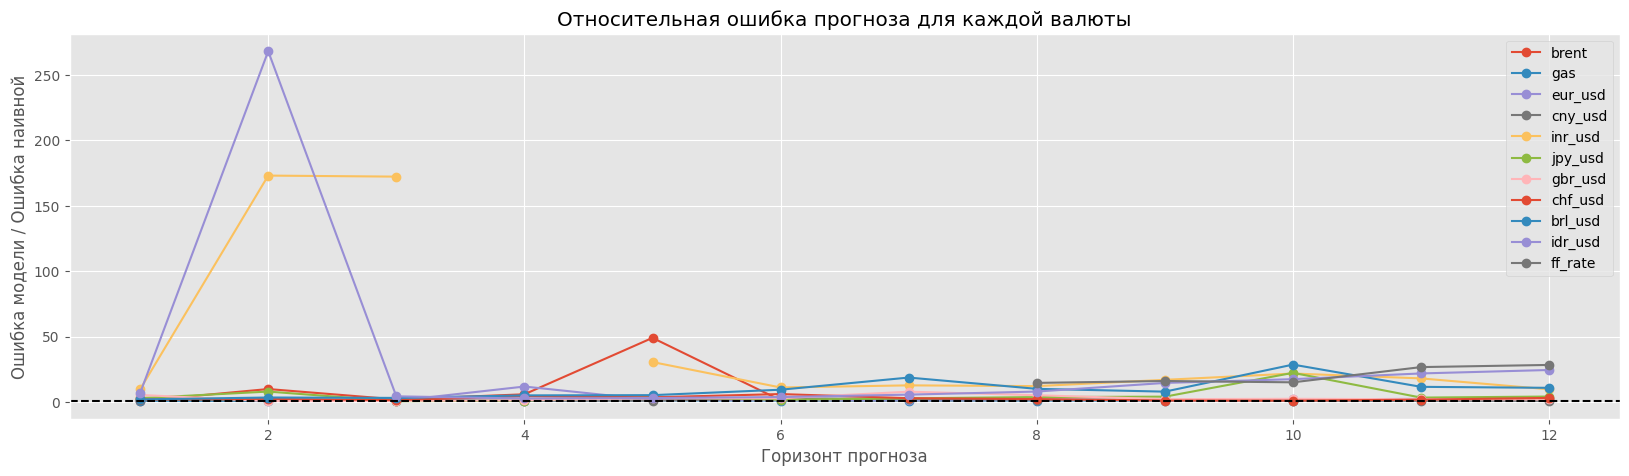

In [ ]:
import matplotlib.pyplot as plt

for currency in relative_errors.index:
    plt.plot(range(1, horizon + 1), relative_errors.loc[currency], label=currency, marker='o')

plt.axhline(1, color='black', linestyle='--')
plt.xlabel('Горизонт прогноза')
plt.ylabel('Ошибка модели / Ошибка наивной')
plt.title('Относительная ошибка прогноза для каждой валюты')
plt.legend()
plt.grid(True)
plt.show()

ff_rate (ставка по федеральным фондам), idr_usd (индонезийская рупия) и inr_usd (индийская рупия) ведут себя очень плохо: ошибка в 100–250 раз больше на первых горизонтах - для этих валют VAR-модель вообще не смогла поймать динамику мб потому что там сильная нерегулярность, нестабильные тренды или частые внешние шоки. По поводу ставки фрс - она может не меняться месяцами, тогда наивный прогноз (ставка такая же как и в прошлом периоде) дает ошибку ноль, тк 0, и уже неважно насколько наша VAR-модель близка к наивной - относительная ошибка равна инф.

chf_usd, gas, eur_usd, gbr_usd, jpy_usd чувствуют себя нормально, модель не сильно хуже наивной.

# Расширения модели (До 3 баллов в зависимости от сложности модификации)

PCA -- не очень честный метод для временных рядов. Предложите, как можно скорректировать процедуру либо найдите метод понижения размерности специально для временных рядов. Кратко опишите суть и примените его для обоих классов выше вместо PCA. Получилось ли улучшить качество модели?

1. (1 балла) Ваше краткое описание методики и почему она подходит для рядов. Если есть статьи, можете приложить ссылки.

2. (2 балла) Реализация, подсчёт метрик и анализ результата.

SSA (Singular Spectrum Analysis) — это метод, который применяется к одномерным временным рядам. Он используется для выявления трендов, циклов и шумов в одном временном ряду, путем разложения его на компоненты через сингулярное разложение (SVD).

MSSA (Multivariate Singular Spectrum Analysis) — это расширение SSA, которое применяется к многомерным временным рядам, т.е. когда у нас есть несколько временных рядов, которые могут быть взаимосвязаны. MSSA помогает анализировать и извлекать общие компоненты, которые могут объяснять взаимосвязи между различными временными рядами.

Что вообще происходит?
Данные временного ряда разбиваются на несколько окон (периодов), чтобы учесть временные зависимости, а потом делаем свд - для каждого окна выполняется сингулярное разложение матрицы, чтобы выделить важные компоненты, которые отражают тренды, цикличность или другие закономерности. MSSA работает с несколькими временными рядами одновременно, что позволяет учитывать возможные взаимосвязи между ними.

Метод ок подходит для анализа данных с временными зависимостями и может быть использован для прогнозирования и выделения скрытых паттернов в многомерных рядах.

В чем отличия от РСА?

* Учитывает временные зависимости и сезонность, чего нет в обычном PCA.
* Работает с многими переменными одновременно (MSSA), в отличие от PCA, которое работает с одной переменной


Статьи:
* Patterns in Time: SSA and MSSA
https://link.springer.com/chapter/10.1007/978-3-662-03744-7_14


##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7